In [1]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division
from censusreporter_api import * 

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
# from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Load the Asthma Discharges by zip

xls_file = pd.ExcelFile('DATA/NYCAsthmaDischarges.xlsx')
dsAsthma = xls_file.parse('Sheet1')

# Cast the zip to string (for future merging)
dsAsthma['zip'] = dsAsthma['zip'].astype(str)

In [3]:
# FDescriptive Stats Helper Function

def generateDescriptiveStats(df1, columnName):
    """ generates a dataframe containing the descriptive stats
   for a particular column
    Arguments:
    df1,input dataframe
    columnName, the column to analize
    """
    
    d = []
    d.append({'Max': df1[columnName].max(),
              'Min': df1[columnName].min(),
              'Median': df1[columnName].median(),
              'Std': df1[columnName].std()})

    descriptiveStats = pd.DataFrame(d)
      
    return descriptiveStats

In [4]:
# Generate descriptive stats for asthma DF

generateDescriptiveStats(dsAsthma, "Rate")

,Max,Median,Min,Std
0,94.8,18.0,0.0,18.893715


In [5]:
# Download a geojson file containing the zip codes
# from fbb git (the original datasource is unrelaiable, we will use the copy)

url = ('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
       'master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson')

if not os.path.isfile("DATA//nyc-zip-code-tabulation-areas-polygons.geojson"):
    os.system("curl -o DATA/nyc-zip-code-tabulation-areas-polygons.geojson " + url)

In [6]:
# Load the geojson file with the zip codes into a geodataframe
geoZips = GeoDataFrame.from_file('DATA//nyc-zip-code-tabulation-areas-polygons.geojson')

geoZips.rename(columns={'postalCode': 'zip'}, inplace=True)
geoZips = geoZips[['PO_NAME', 'STATE', 'Shape_Area',
                     'Shape_Leng', 'borough', 'geometry','zip']]

# Quick exploration of the data
geoZips.head()

,PO_NAME,STATE,Shape_Area,Shape_Leng,borough,geometry,zip
0,Jackson Heights,NY,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,NY,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,NY,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Bellerose,NY,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Fresh Meadows,NY,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [7]:
# Merge the geoZips with the Asthma Discharges

# Cast of the values  to string (will attempt substraction)!

geoDfAsthmaByZip = pd.merge(geoZips, dsAsthma, on=['zip'])

In [8]:
geoDfAsthmaByZip.head()

,PO_NAME,STATE,Shape_Area,Shape_Leng,borough,geometry,zip,2012-2014,Rate
0,Jackson Heights,NY,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,262,12.8
1,Glen Oaks,NY,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,50,12.6
2,Bellerose,NY,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,65,11.3
3,Fresh Meadows,NY,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,133,10.3
4,Elmhurst,NY,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373,363,11.5


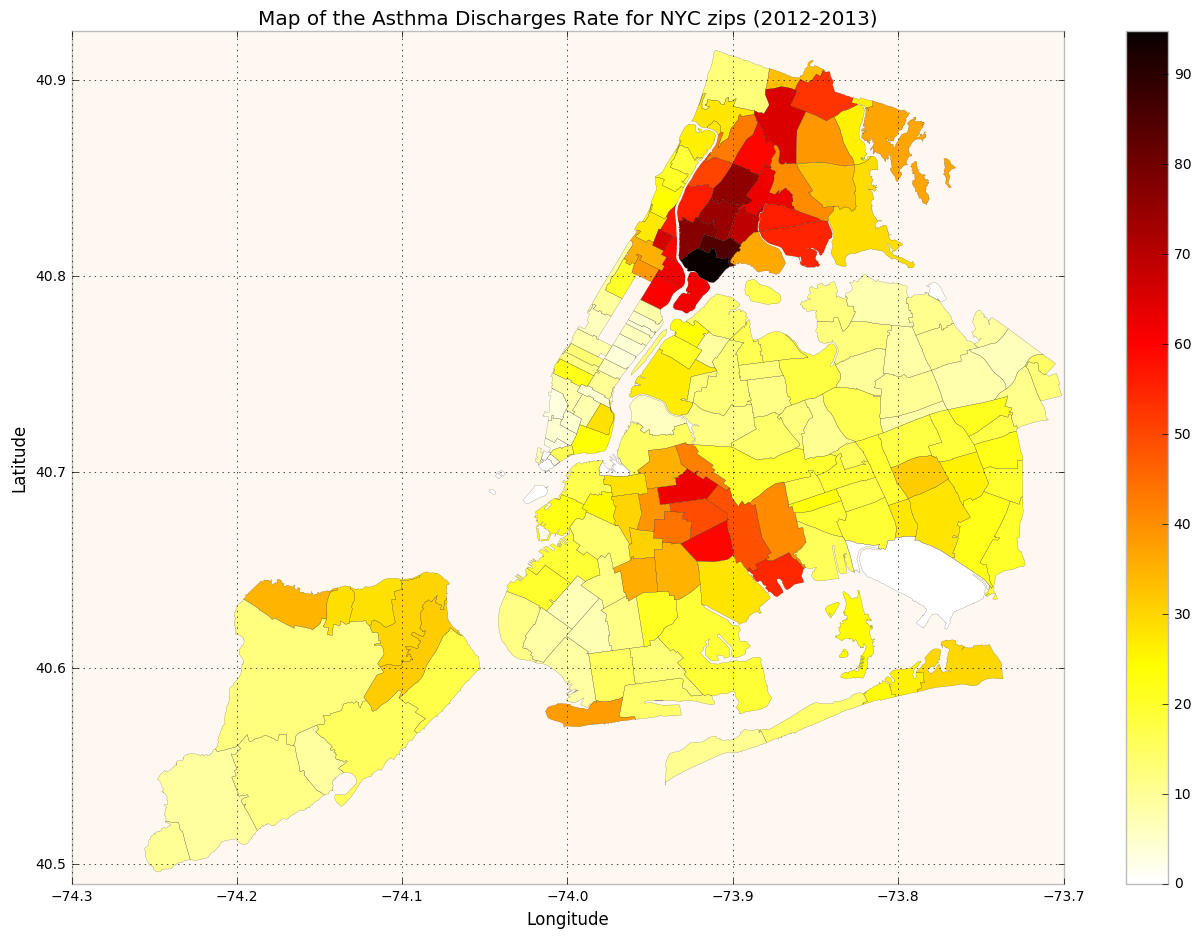

In [190]:
# Create Coloropeth with the Asthma Rate for NYC ZIps

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 11))

geoDfAsthmaByZip.plot(column='Rate', cmap='hot_r', alpha=1,
                        linewidth=0.1, ax=ax1)
ax1.set_title('Map of the Asthma Discharges Rate for NYC zips (2012-2013)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.set_ylim(40.49, 40.925)


normalize = mcolors.Normalize(vmin=geoDfAsthmaByZip.Rate.min(),
                              vmax=geoDfAsthmaByZip.Rate.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoDfAsthmaByZip.Rate)
pl.colorbar(scalarmappaple, ax=ax1)

In [191]:
geoDfAsthmaByZip.count()

PO_NAME       191
STATE         191
Shape_Area    191
Shape_Leng    191
borough       191
geometry      191
zip           191
2012-2014     191
Rate          191
dtype: int64

In [10]:
# Create helper function to get data from Carto DB
# This Function is based on FBB SQL notebook reference

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [11]:
# Setting the SQL_SOURCE variable (FBB Carto SQL Endpoint)
# This variable will be used on all SQL queries

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [12]:
# First census data SQL query: 2010
dec10_query = '''
SELECT geo_id, geo_id2, the_geom, 
hd01_s001 as totalPolulation, 
hd02_s078 as whitePopulationPercentage, 
hd01_s020 as medianAge
FROM dec_10_sf1_sf1dp1
'''

dec10_query = '''
SELECT dec_10_sf1_sf1dp1.geo_id, dec_10_sf1_sf1dp1.geo_id2, dec_10_sf1_sf1dp1.the_geom,
dec_10_sf1_sf1dp1.hd01_s001 as totalPolulation, 
dec_10_sf1_sf1dp1.hd02_s078 as whitePopulationPercentage, 
dec_10_sf1_sf1dp1.hd01_s020 as medianAge,
ACS_10_5YR_S1901_with_ann.HC01_EST_VC13 as medianHouseholdIncome
FROM dec_10_sf1_sf1dp1, ACS_10_5YR_S1901_with_ann
WHERE dec_10_sf1_sf1dp1.geo_id = ACS_10_5YR_S1901_with_ann.geo_id
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe

datastream = queryCartoDB(dec10_query, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
dec10DF = GeoDataFrame.from_features(datageo['features'])

In [13]:
# in order to aggregate the census tracts to zipcodes we will use
# The US census bureau Zip Code Tabulation Area relationship files
# These files created by examining the list of zip codes by census block
# and assigning to that block the most frequently ocurring ZIP code
# the blocks are later aggregated into larger areas.
# Details on how the USCB create these relationship files can be found here:
# http://www2.census.gov/geo/pdfs/education/brochures/ZCTAs.pdf

url = ('http://www2.census.gov/geo/docs/maps-data/data/rel/zcta_tract_rel_10.txt')

if not os.path.isfile("DATA//zcta_tract_rel_10.txt"):
    os.system("curl -o DATA/zcta_tract_rel_10.txt "+ url)

# Be careful of using dtype=object otherwise it converts the TRACT to an int!
# and takes out the leading zeroes (which makes it unsuitable for the merge)
zcta_tractDF = pd.read_csv("DATA/zcta_tract_rel_10.txt", dtype=object)
zcta_tractDF.head()

,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,...,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,00601,72,001,956300,72001956300,4271,1706,44663250,44572589,18570,...,44924558,44833897,23,22.03,26.67,26.74,98.5,98.33,99.42,99.42
1,00601,72,001,956400,72001956400,2384,1037,32830481,32492074,18570,...,37782601,37191697,12.84,13.39,19.61,19.5,79.6,80.14,86.89,87.36
2,00601,72,001,956500,72001956500,3126,1240,44969548,44809680,18570,...,44969548,44809680,16.83,16.01,26.85,26.89,100,100,100,100
3,00601,72,001,956600,72001956600,2329,972,1981101,1981101,18570,...,1981101,1981101,12.54,12.55,1.18,1.19,100,100,100,100
4,00601,72,001,956700,72001956700,2053,948,1380041,1380041,18570,...,1380041,1380041,11.06,12.24,.82,.83,100,100,100,100


In [14]:
# Fifth (and last!) census data SQL query: census tracts 
    
tractsQuery = '''
SELECT *
FROM table_2010_census_tracts
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
datastream = queryCartoDB(tractsQuery, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
censusTractDF = GeoDataFrame.from_features(datageo['features'])

In [15]:
# Create a column to join the previous obtained datasets with the Census Tract derived from the geo_id

# The code bellow is based on the Hint by fedhere
# https://docs.google.com/document/d/1mt0lrTvupF2CLsyUnqufWLw28BKUWR6d4MnWAINwo-g/edit

countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

censusTractDF['allcodes'] = list(zip(censusTractDF.boro_name, censusTractDF.ct_2010))
censusTractDF['geo_id']  = censusTractDF[['allcodes']].applymap(lambda x: 
                            ("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

censusTractDF.head()

,boro_code,boro_ct_2010,boro_name,cartodb_id,cdeligibil,ct_2010,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id
0,3,3050804,Brooklyn,998,E,050804,508.04,"(POLYGON ((-73.96140699999999 40.65217, -73.96...",BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804
1,3,3027500,Brooklyn,1261,I,027500,275,"(POLYGON ((-73.935008 40.682764, -73.937932 40...",BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500
2,2,2009200,Bronx,1294,E,009200,92,"(POLYGON ((-73.847279 40.829315, -73.847320999...",BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200
3,4,4099100,Queens,1306,I,099100,991,"(POLYGON ((-73.791793 40.789352, -73.791563999...",QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100
4,4,4000100,Queens,1407,I,000100,1,"(POLYGON ((-73.949113 40.754524, -73.949144 40...",QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100


In [16]:
# Extract only New York and necessary columns
# New York State ID is 36
# New York City Counties are

#005 - Bronx
#047 - Kings (Brooklyn)
#061 - New York (Manhattan)
#081 - Queens
#085 - Richmond (Staten Island)

zcta_tractDF = zcta_tractDF[['ZCTA5','COUNTY','TRACT']][(zcta_tractDF.STATE == '36')\
                                               & ((zcta_tractDF.COUNTY == '005')\
                                                 |(zcta_tractDF.COUNTY == '047')\
                                                  |(zcta_tractDF.COUNTY == '061')\
                                                  |(zcta_tractDF.COUNTY == '081')\
                                                  |(zcta_tractDF.COUNTY == '085')\
                                                 )]

In [17]:
zcta_tractDF.head()
#zcta_tractDF.count()

,ZCTA5,COUNTY,TRACT
9554,10001,061,005800
9555,10001,061,007600
9556,10001,061,009100
9557,10001,061,009300
9558,10001,061,009500


In [18]:
# Tweak the dec10DF for the merge rename the ct to TRACT
# Create a COUNTY column sing the FBB HIN on geo_id format

censusTractDF.rename(columns={'ct_2010': 'TRACT'}, inplace=True)
censusTractDF['COUNTY'] = censusTractDF.geo_id.str[11:-6]

#censusTractDF.count()
censusTractDF.head()

,boro_code,boro_ct_2010,boro_name,cartodb_id,cdeligibil,TRACT,ctlabel,geometry,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id,COUNTY
0,3,3050804,Brooklyn,998,E,050804,508.04,"(POLYGON ((-73.96140699999999 40.65217, -73.96...",BK42,Flatbush,4015,1110945.63082,4305.94762341,"(Brooklyn, 050804)",1400000US36047050804,047
1,3,3027500,Brooklyn,1261,I,027500,275,"(POLYGON ((-73.935008 40.682764, -73.937932 40...",BK35,Stuyvesant Heights,4003,1743574.56294,5390.78775209,"(Brooklyn, 027500)",1400000US36047027500,047
2,2,2009200,Bronx,1294,E,009200,92,"(POLYGON ((-73.847279 40.829315, -73.847320999...",BX59,Westchester-Unionport,3709,3278193.62083,9143.90356952,"(Bronx, 009200)",1400000US36005009200,005
3,4,4099100,Queens,1306,I,099100,991,"(POLYGON ((-73.791793 40.789352, -73.791563999...",QN49,Whitestone,4103,11557974.9909,17092.0365078,"(Queens, 099100)",1400000US36081099100,081
4,4,4000100,Queens,1407,I,000100,1,"(POLYGON ((-73.949113 40.754524, -73.949144 40...",QN31,Hunters Point-Sunnyside-West Maspeth,4109,12286326.8522,40345.5358859,"(Queens, 000100)",1400000US36081000100,081


In [19]:
# Merge!
censusTracZiptDF = pd.merge(zcta_tractDF, censusTractDF,on=['TRACT','COUNTY'])
censusTracZiptDF.head()
censusTracZiptDF.count()

ZCTA5           2865
COUNTY          2865
TRACT           2865
boro_code       2865
boro_ct_2010    2865
boro_name       2865
cartodb_id      2865
cdeligibil      2865
ctlabel         2865
geometry        2865
ntacode         2865
ntaname         2865
puma            2865
shape_area      2865
shape_leng      2865
allcodes        2865
geo_id          2865
dtype: int64

In [20]:
# Rename column for future merge
censusTracZiptDF.rename(columns={'ZCTA5': 'zip'}, inplace=True)

In [21]:
census2010DF = pd.merge (dec10DF, censusTractDF, on=['geo_id'])

In [22]:
# Clean and Display the tables with the necessary columns for the cloroplath

census2010DFClean = census2010DF[['geo_id', 'medianage','totalpolulation','whitepopulationpercentage',\
                                  'boro_name', 'medianhouseholdincome', 'geometry_y']]

census2010DFClean.whitepopulationpercentage =\
pd.to_numeric(census2010DFClean.whitepopulationpercentage, errors='coerce')

census2010DFClean.medianage =\
pd.to_numeric(census2010DFClean.medianage, errors='coerce')

census2010DFClean.totalpolulation =\
pd.to_numeric(census2010DFClean.totalpolulation, errors='coerce')

census2010DFClean.medianhouseholdincome =\
pd.to_numeric(census2010DFClean.medianhouseholdincome, errors='coerce')

census2010DFClean = census2010DFClean[(census2010DFClean != 0).all(1)]

census2010DFClean = census2010DFClean.dropna()
census2010DFClean.head()

C:\Program Files\Anaconda2\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,geo_id,medianage,totalpolulation,whitepopulationpercentage,boro_name,medianhouseholdincome,geometry_y
1,1400000US36005000200,33.9,4334,30.7,Bronx,59826.0,"(POLYGON ((-73.856516 40.805241, -73.856523999..."
2,1400000US36005000400,34.1,5503,27.2,Bronx,71968.0,"(POLYGON ((-73.846107 40.8131, -73.846467 40.8..."
3,1400000US36005001600,35.0,5643,27.6,Bronx,30355.0,"(POLYGON ((-73.855136 40.822436, -73.854967 40..."
4,1400000US36005001900,30.6,1917,30.8,Bronx,25093.0,"(POLYGON ((-73.89680900000001 40.795808, -73.8..."
5,1400000US36005002000,31.0,8731,22.7,Bronx,24939.0,"(POLYGON ((-73.862464 40.819247, -73.862078 40..."


In [23]:
census2010DFClean.totalpolulation.sum()
census2010DFClean.count()

geo_id                       2109
medianage                    2109
totalpolulation              2109
whitepopulationpercentage    2109
boro_name                    2109
medianhouseholdincome        2109
geometry_y                   2109
dtype: int64

In [24]:
# Merge ZIPs with the 2010DF
census2010DFCleanZip = pd.merge(census2010DFClean, censusTracZiptDF,on='geo_id')
census2010DFCleanZip.count()

geo_id                       2800
medianage                    2800
totalpolulation              2800
whitepopulationpercentage    2800
boro_name_x                  2800
medianhouseholdincome        2800
geometry_y                   2800
zip                          2800
COUNTY                       2800
TRACT                        2800
boro_code                    2800
boro_ct_2010                 2800
boro_name_y                  2800
cartodb_id                   2800
cdeligibil                   2800
ctlabel                      2800
geometry                     2800
ntacode                      2800
ntaname                      2800
puma                         2800
shape_area                   2800
shape_leng                   2800
allcodes                     2800
dtype: int64

In [25]:
# Will furtrher refine the dataframe and aggregate by taking the mean on all census values
census2010DFCleanZip = census2010DFCleanZip[['zip','medianage','whitepopulationpercentage',\
                                            'medianhouseholdincome']]

census2010DFCleanZip = census2010DFCleanZip.groupby(['zip'], as_index=False).mean()

In [26]:
census2010DFCleanZip.head()

,zip,medianage,whitepopulationpercentage,medianhouseholdincome
0,10001,35.118182,64.836364,92754.909091
1,10002,39.733333,39.680000,39449.400000
2,10003,32.653846,77.446154,93893.846154
3,10004,30.620000,71.000000,122729.200000
4,10005,29.033333,73.466667,116870.333333


In [27]:
# Merge the geoZips with the Asthma Discharges

# Cast of the values  to string (will attempt substraction)!

geoCensus2010DFCleanZip = pd.merge(geoZips, census2010DFCleanZip, on=['zip'])

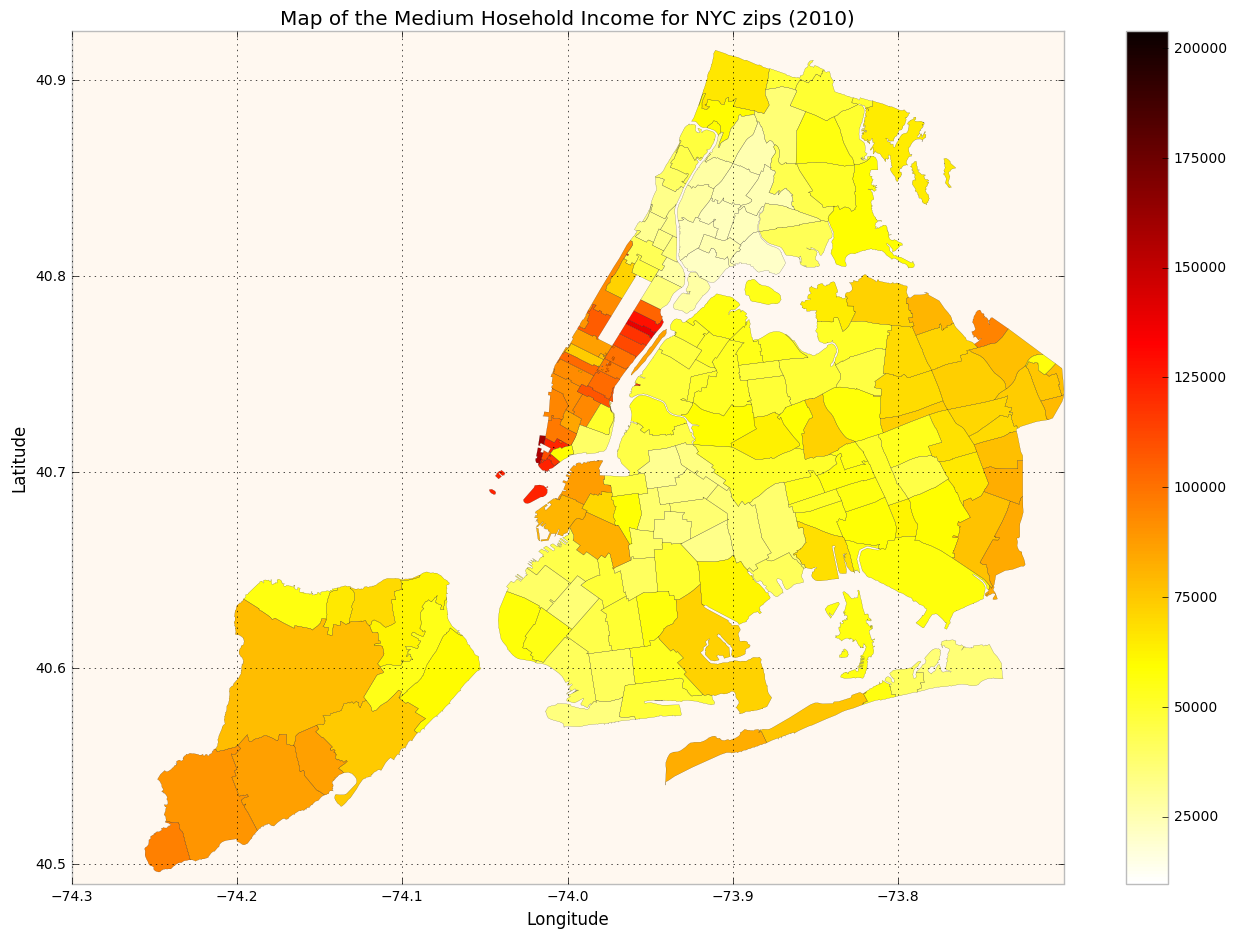

In [192]:
# Create Coloropeth with the Asthma Rate for NYC ZIps

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 11))

geoCensus2010DFCleanZip.plot(column='medianhouseholdincome', cmap='hot_r', alpha=1,
                          linewidth=0.1, ax=ax1)

ax1.set_title('Map of the Medium Hosehold Income for NYC zips (2010)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.set_ylim(40.49, 40.925)
ax1.set_xlim(-74.3, -73.7)

normalize = mcolors.Normalize(vmin=geoCensus2010DFCleanZip.medianhouseholdincome.min(),
                              vmax=geoCensus2010DFCleanZip.medianhouseholdincome.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(geoCensus2010DFCleanZip.medianhouseholdincome)
pl.colorbar(scalarmappaple, ax=ax1)

In [189]:
geoCensus2010DFCleanZip.count()

PO_NAME                      217
STATE                        217
Shape_Area                   217
Shape_Leng                   217
borough                      217
geometry                     217
zip                          217
medianage                    217
whitepopulationpercentage    217
medianhouseholdincome        217
dtype: int64

In [299]:
# Download the curated summary census data file for 2000
xls_file = pd.ExcelFile('DATA\ll84-nyc.xlsx')
dsBuildings = xls_file.parse('2013 NYC Benchmark Data')
dsBuildings.head()

,Record Number,"NYC Borough, Block, and Lot",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers,Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions,Direct GHG Emissions,Indirect GHG Emissions,Reported Property Floor Area,DOF Property Floor Area,Primary Property Type - Self Selected,DOF Number of Buildings
0,16099,4.084010e+09,NaN,4084010096,4453435,NaN,NaN,Queens,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,966.7,806.6,160.1,91968,NaN,Multifamily Housing,NaN
1,500,1.005050e+09,NaN,1005050001,1007817,150,VARICK STREET,Manhattan,10013.0,Filed,...,Yes,ABS,44,1392.3,337.9,1054.4,235370,214110.0,Distribution Center,1
2,5017,1.021420e+09,NaN,1021420100,1063495,4079,BROADWAY,Manhattan,10032.0,Filed,...,No,None,Not Available,673.6,541.8,131.8,64806,64816.0,Multifamily Housing,1
3,5116,1.021750e+09,NaN,1021750080,1064235,60,SHERMAN AVENUE,Manhattan,10040.0,Filed,...,No,None,Not Available,485,403,82,62839,62847.0,Multifamily Housing,1
4,363,1.003360e+09,NaN,1003360005,1088884,16,BIALYSTOKER PLACE,Manhattan,10002.0,Filed,...,No,None,Not Available,435.5,290,145.5,98000,98052.0,Multifamily Housing,1


In [300]:
# Filter only office buildings (using self reported clasification)
#officeBuildings = dsBuildings[dsBuildings["Primary Property Type - Self Selected"] == 'Office']
selectedBuildings = dsBuildings
selectedBuildings.rename(columns={"Weather Normalized Site EUI" : "WNSEUI"}, inplace=True)

In [301]:
selectedBuildings.head()

,Record Number,"NYC Borough, Block, and Lot",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers,Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions,Direct GHG Emissions,Indirect GHG Emissions,Reported Property Floor Area,DOF Property Floor Area,Primary Property Type - Self Selected,DOF Number of Buildings
0,16099,4.084010e+09,NaN,4084010096,4453435,NaN,NaN,Queens,NaN,Not on Covered Buildings List,...,NaN,None,Not Available,966.7,806.6,160.1,91968,NaN,Multifamily Housing,NaN
1,500,1.005050e+09,NaN,1005050001,1007817,150,VARICK STREET,Manhattan,10013.0,Filed,...,Yes,ABS,44,1392.3,337.9,1054.4,235370,214110.0,Distribution Center,1
2,5017,1.021420e+09,NaN,1021420100,1063495,4079,BROADWAY,Manhattan,10032.0,Filed,...,No,None,Not Available,673.6,541.8,131.8,64806,64816.0,Multifamily Housing,1
3,5116,1.021750e+09,NaN,1021750080,1064235,60,SHERMAN AVENUE,Manhattan,10040.0,Filed,...,No,None,Not Available,485,403,82,62839,62847.0,Multifamily Housing,1
4,363,1.003360e+09,NaN,1003360005,1088884,16,BIALYSTOKER PLACE,Manhattan,10002.0,Filed,...,No,None,Not Available,435.5,290,145.5,98000,98052.0,Multifamily Housing,1


In [302]:
# Cleanup
selectedBuildings = selectedBuildings[['Record Number', 'NYC Borough, Block, and Lot ',\
                                   'Zip Code','Total GHG Emissions','WNSEUI',\
                                  'DOF Property Floor Area ']]

selectedBuildings.WNSEUI = pd.to_numeric(selectedBuildings.WNSEUI, errors='coerce')
selectedBuildings = selectedBuildings.dropna()

In [303]:
selectedBuildings["WNSEUI"].count()

8890

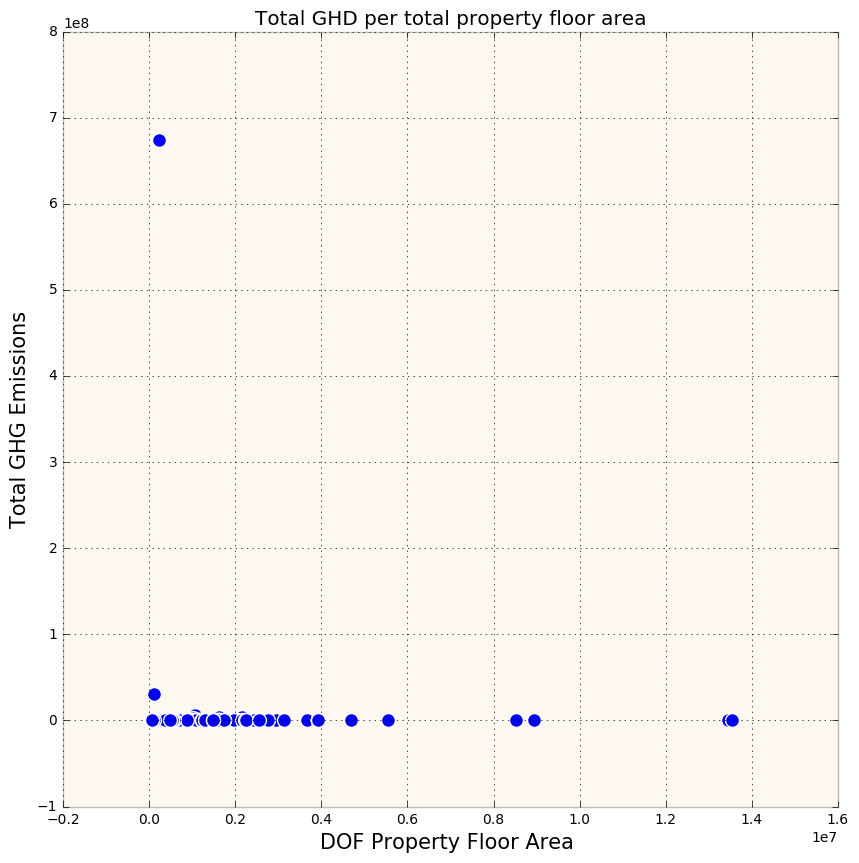

In [304]:
# Explore the data (Start looking for outliers, firther cleanup)

pl.figure(figsize=(10,10))
pl.scatter(selectedBuildings['DOF Property Floor Area '], \
           selectedBuildings['Total GHG Emissions'], s=100)
pl.xlabel("DOF Property Floor Area ", fontsize=15)
pl.ylabel("Total GHG Emissions", fontsize=15)
pl.title('Total GHD per total property floor area') ;

In [305]:
selectedBuildings['Total GHG Emissions'].max()

674366502.4

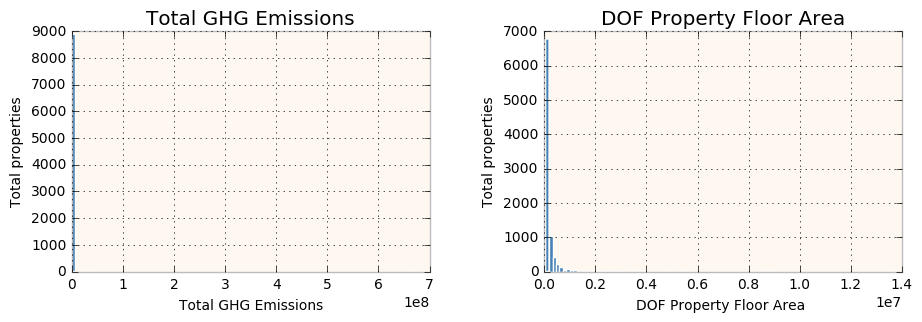

In [306]:
#  Looj at the distribution of both Total Emissions and Property floor area

pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.title('Total GHG Emissions')
pl.hist(selectedBuildings['Total GHG Emissions'],bins = 100)
pl.xlabel("Total GHG Emissions", fontsize=10)
pl.ylabel("Total properties", fontsize=10)

#Subplot II historgram for the collection of sample means
pl.subplot(122)
pl.title('DOF Property Floor Area')
pl.hist(selectedBuildings['DOF Property Floor Area '],bins = 100)
pl.xlabel("DOF Property Floor Area ", fontsize=10)
pl.ylabel("Total properties", fontsize=10)
pl.tight_layout(pad=3.5)
pl.show()


The distributions show some extreme values, outliers that are likely to be wrongly entered values.
WIll furhter refine

In [307]:
selectedBuildings['Total GHG Emissions'].max()

674366502.4

In [308]:
# Remove that outlier
selectedBuildings = selectedBuildings[selectedBuildings['Total GHG Emissions'] < 674366502]

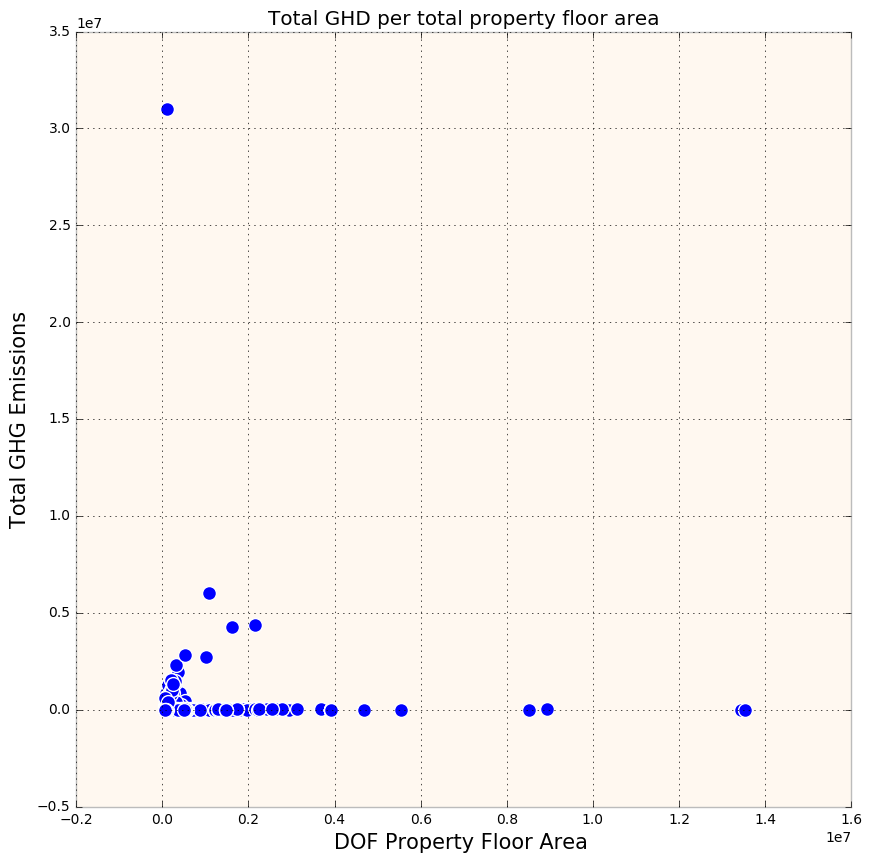

In [309]:
# Explore the data (Start looking for outliers, firther cleanup)

pl.figure(figsize=(10,10))
pl.scatter(selectedBuildings['DOF Property Floor Area '], \
           selectedBuildings['Total GHG Emissions'], s=100)
pl.xlabel("DOF Property Floor Area ", fontsize=15)
pl.ylabel("Total GHG Emissions", fontsize=15)
pl.title('Total GHD per total property floor area') ;

In [365]:
# Remove that outlier
selectedBuildings = selectedBuildings[selectedBuildings['Total GHG Emissions'] < 10000]
selectedBuildings = selectedBuildings[selectedBuildings['DOF Property Floor Area '] < 400000]

selectedBuildings.count()

zip                         8055
Total GHG Emissions         8055
WNSEUI                      8055
DOF Property Floor Area     8055
totalGHGperSqF              8055
dtype: int64

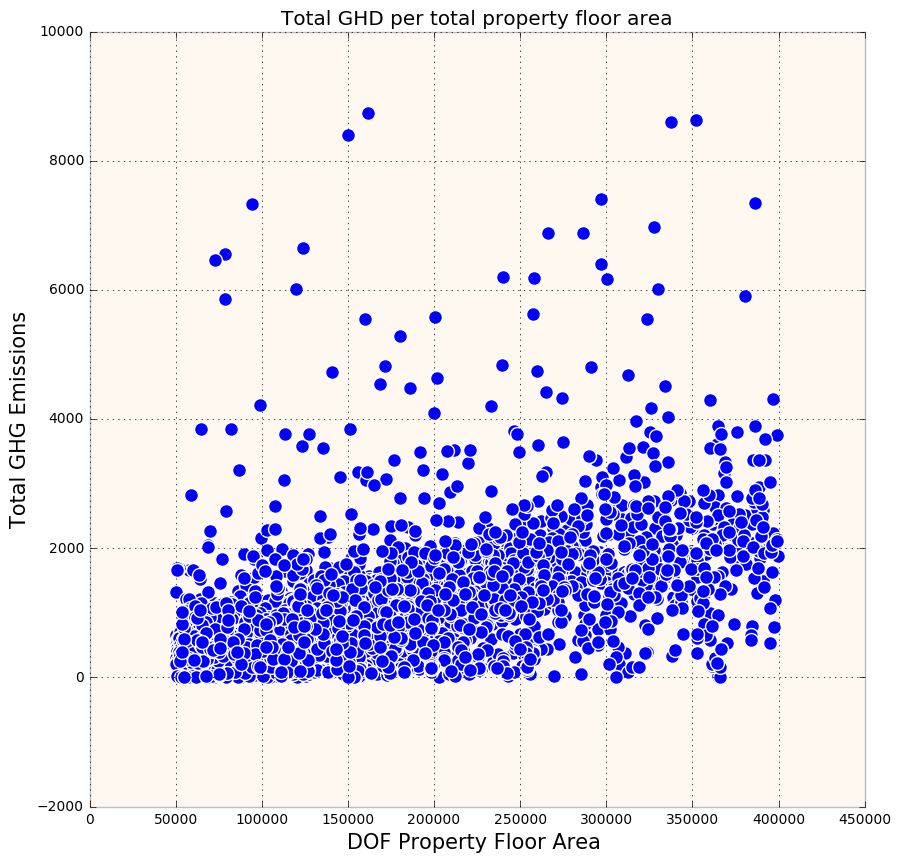

In [311]:
# Explore the data (Start looking for outliers, firther cleanup)

pl.figure(figsize=(10,10))
pl.scatter(selectedBuildings['DOF Property Floor Area '], \
           selectedBuildings['Total GHG Emissions'], s=100)
pl.xlabel("DOF Property Floor Area ", fontsize=15)
pl.ylabel("Total GHG Emissions", fontsize=15)
pl.title('Total GHD per total property floor area') ;

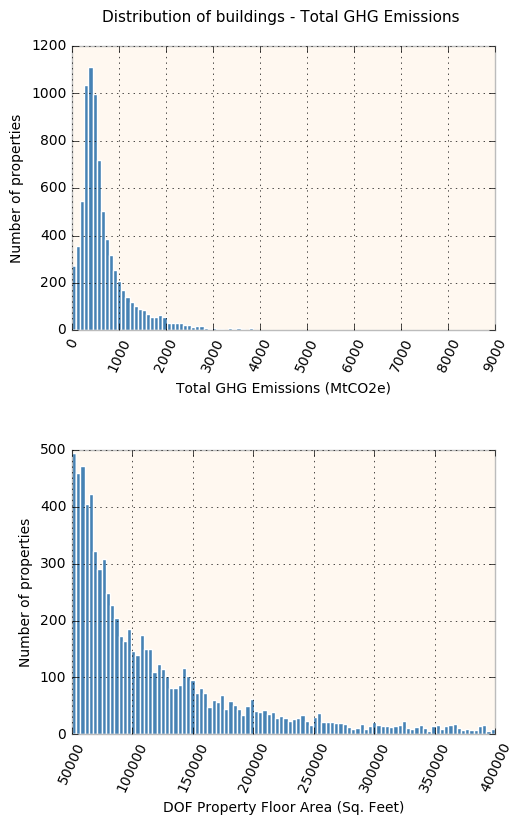

In [367]:
# Look at the distribution of both Total Emissions and Property floor area
# After removing outliers

# Subplot I (GHG Emissions)
pl.figure(figsize=(6, 9))
pl.subplot(211)
pl.title('Distribution of buildings - Total GHG Emissions \n', fontsize=11)
pl.hist(selectedBuildings['Total GHG Emissions'],bins = 100)
pl.xlabel("Total GHG Emissions (MtCO2e)", fontsize=10)
pl.ylabel("Number of properties", fontsize=10)
pl.xticks(rotation='65')

# Subplot II (Floor Property Area)
pl.subplot(212)
#pl.title('DOF Property Floor Area')
pl.hist(selectedBuildings['DOF Property Floor Area '],bins = 100)
pl.xlabel("DOF Property Floor Area (Sq. Feet)", fontsize=10)
pl.ylabel("Number of properties", fontsize=10)
pl.xticks(rotation='65')
pl.tight_layout(pad=3.5)
pl.show()  

In [313]:
selectedBuildings.count()

Record Number                   8055
NYC Borough, Block, and Lot     8055
Zip Code                        8055
Total GHG Emissions             8055
WNSEUI                          8055
DOF Property Floor Area         8055
dtype: int64

In [314]:
selectedBuildings['totalGHGperSqF'] = selectedBuildings['Total GHG Emissions'] / \
selectedBuildings['DOF Property Floor Area ']

In [315]:
selectedBuildings.head()

,Record Number,"NYC Borough, Block, and Lot",Zip Code,Total GHG Emissions,WNSEUI,DOF Property Floor Area,totalGHGperSqF
1,500,1.005050e+09,10013.0,1392.3,81.9,214110.0,0.00650273
2,5017,1.021420e+09,10032.0,673.6,137.5,64816.0,0.0103925
3,5116,1.021750e+09,10040.0,485,103.0,62847.0,0.00771715
4,363,1.003360e+09,10002.0,435.5,74.0,98052.0,0.00444152
5,6876,2.040830e+09,10461.0,133.7,36.3,53285.0,0.00250915


In [316]:
# zip 2012-2014 Rate

# Cast the zip to string, rename and reformat for future merge

selectedBuildings['Zip Code'] = selectedBuildings['Zip Code'].astype(str)
selectedBuildings.rename(columns={'Zip Code': 'zip'}, inplace=True)

selectedBuildings.zip = selectedBuildings.zip.str[:-2]

selectedBuildings = selectedBuildings[['zip', 'Total GHG Emissions','WNSEUI',
                                      'DOF Property Floor Area ','totalGHGperSqF']]

selectedBuildings.head()

,zip,Total GHG Emissions,WNSEUI,DOF Property Floor Area,totalGHGperSqF
1,10013,1392.3,81.9,214110.0,0.00650273
2,10032,673.6,137.5,64816.0,0.0103925
3,10040,485,103.0,62847.0,0.00771715
4,10002,435.5,74.0,98052.0,0.00444152
5,10461,133.7,36.3,53285.0,0.00250915


In [317]:
# Now we will characterize the zip codes based on the average GHG emissions per SQ Feet
# For its buildings. Data conversion is needed to apply means

selectedBuildings['Total GHG Emissions'] =\
pd.to_numeric(selectedBuildings['Total GHG Emissions'], errors='coerce')

selectedBuildings.totalGHGperSqF =\
pd.to_numeric(selectedBuildings.totalGHGperSqF, errors='coerce')

selectedBuildings.head()


,zip,Total GHG Emissions,WNSEUI,DOF Property Floor Area,totalGHGperSqF
1,10013,1392.3,81.9,214110.0,0.006503
2,10032,673.6,137.5,64816.0,0.010392
3,10040,485.0,103.0,62847.0,0.007717
4,10002,435.5,74.0,98052.0,0.004442
5,10461,133.7,36.3,53285.0,0.002509


In [324]:
buildingGHGperSqFeetByZip = selectedBuildings.groupby(['zip'], as_index=False).mean()

In [370]:
buildingGHGperSqFeetByZip.count()

zip                         174
Total GHG Emissions         174
WNSEUI                      174
DOF Property Floor Area     174
totalGHGperSqF              174
dtype: int64

In [326]:
# Now we have the three datasets
# Will merge it to create a consolidated dataset
# That contains all the elements for the analysis

# zip 2012-2014 Rate
geoDfAsthmaByZip = geoDfAsthmaByZip[['zip', '2012-2014','Rate']]

geoCensus2010DFCleanZip
buildingGHGperSqFeetByZip

dsAsthmaAndCensysByZip = pd.merge(geoDfAsthmaByZip, geoCensus2010DFCleanZip, on=['zip'])
dsConsolidatedByZip = pd.merge(dsAsthmaAndCensysByZip, buildingGHGperSqFeetByZip, on=['zip'])

In [327]:
dsConsolidatedByZip.head()

,zip,2012-2014,Rate,PO_NAME,STATE,Shape_Area,Shape_Leng,borough,geometry,medianage,whitepopulationpercentage,medianhouseholdincome,Total GHG Emissions,WNSEUI,DOF Property Floor Area,totalGHGperSqF
0,11372,262,12.8,Jackson Heights,NY,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,36.806667,41.920000,48083.733333,552.320370,86.152778,101827.787037,0.005377
1,11004,50,12.6,Glen Oaks,NY,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,44.420000,46.440000,75154.000000,1174.827273,165.881818,149115.909091,0.007850
2,11426,65,11.3,Bellerose,NY,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,40.128571,40.171429,73669.571429,1075.975000,113.025000,131379.500000,0.007854
3,11365,133,10.3,Fresh Meadows,NY,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,40.814286,41.735714,68992.428571,580.730000,142.476667,172077.966667,0.003856
4,11373,363,11.5,Elmhurst,NY,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,35.856000,29.996000,48736.960000,583.179121,89.389011,97972.923077,0.005872


In [330]:
# Cast the dataframe to geodataframe
dsConsolidatedByZip = GeoDataFrame(dsConsolidatedByZip, geometry=dsConsolidatedByZip.geometry)


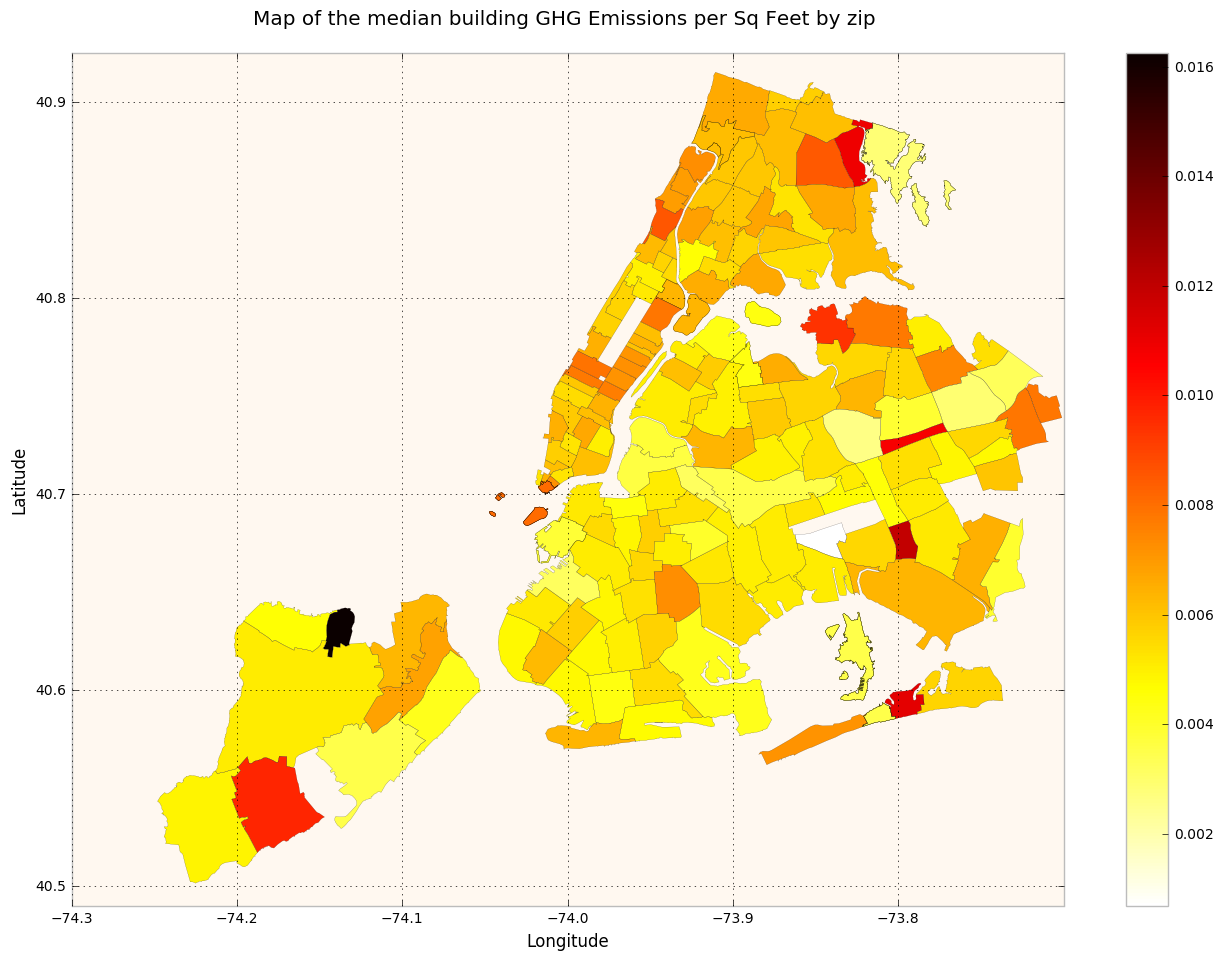

In [371]:
# Create Coloropeth with the Asthma Rate for NYC ZIps

fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(16, 11))

dsConsolidatedByZip.plot(column='totalGHGperSqF', cmap='hot_r', alpha=1,
                          linewidth=0.1, ax=ax1)

ax1.set_title('Map of the median building GHG Emissions per Sq Feet by zip \n')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.set_ylim(40.49, 40.925)
ax1.set_xlim(-74.3, -73.7)

normalize = mcolors.Normalize(vmin=dsConsolidatedByZip.totalGHGperSqF.min(),
                              vmax=dsConsolidatedByZip.totalGHGperSqF.max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(dsConsolidatedByZip.totalGHGperSqF)
pl.colorbar(scalarmappaple, ax=ax1)

In [395]:
# Try to find correlations between the different zip charactersitics

corrIncomeTotalGHGperSqF = (np.corrcoef(dsConsolidatedByZip.medianhouseholdincome,\
                            dsConsolidatedByZip.totalGHGperSqF)[0, 1])

corrMedianAge = (np.corrcoef(dsConsolidatedByZip.medianage,\
                            dsConsolidatedByZip.Rate)[0, 1])
  
corrWhitePopulationPercentage = (np.corrcoef(dsConsolidatedByZip.Rate,\
                            dsConsolidatedByZip.whitepopulationpercentage)[0, 1])

corrMedianhouseholdincome = (np.corrcoef(dsConsolidatedByZip.Rate,\
                            dsConsolidatedByZip.medianhouseholdincome)[0, 1])
    
corrTotalGHGperSqF = (np.corrcoef(dsConsolidatedByZip.Rate,\
                            dsConsolidatedByZip.totalGHGperSqF)[0, 1])

In [398]:
print ("The correlation coefficient between Building Energy Performance and" 
       " Mediam Household income is " +  str(corrIncomeTotalGHGperSqF))

The correlation coefficient between Building Energy Performance and Mediam Household income is 0.259481106487


In [376]:
pearsons = {'Median Age': corrMedianAge, 'White Population Percentage': corrWhitePopulationPercentage, \
             'Median Household Income': corrMedianhouseholdincome, 'Total GHG per Sq. F' : corrTotalGHGperSqF }

sorted_pearsons = sorted(pearsons.items(), key=operator.itemgetter(1))

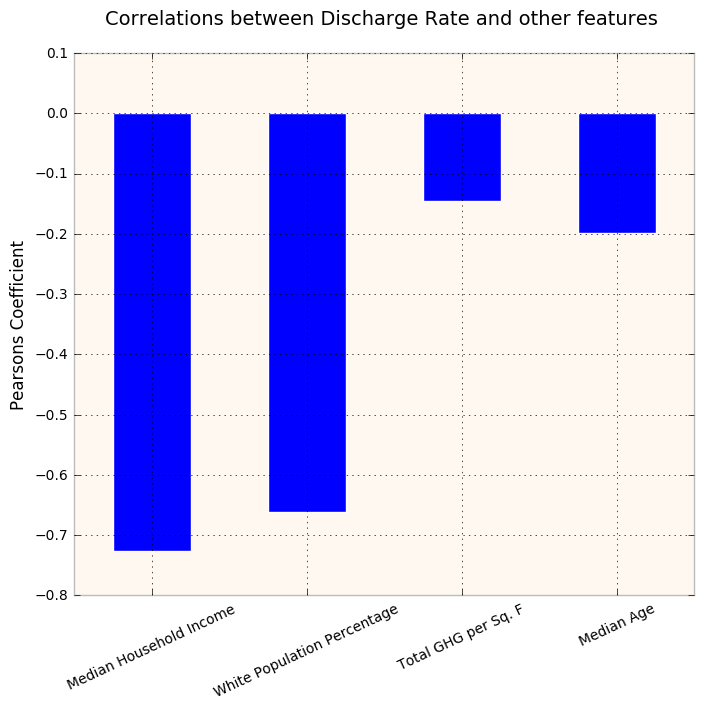

In [377]:
# Create a historgram with the features
fig, (ax1) = pl.subplots(nrows=1, ncols=1, figsize=(8, 7))
X = np.arange(len(pearsons))
ax1.bar(X, pearsons.values(), align='center', width=0.5)
ind = np.arange(len(pearsons))
width = 0.50
xTickMarks = pearsons.keys()
ax1.set_xticks(ind)
xtickNames = ax1.set_xticklabels(xTickMarks)
pl.setp(xtickNames, rotation=25, fontsize=10)
ax1.set_ylabel('Pearsons Coefficient')
ymax = max(pearsons.values())
ax1.set_title('Correlations between Discharge Rate and other features \n' , fontsize=14)
#ax2.ylim(0, ymax)

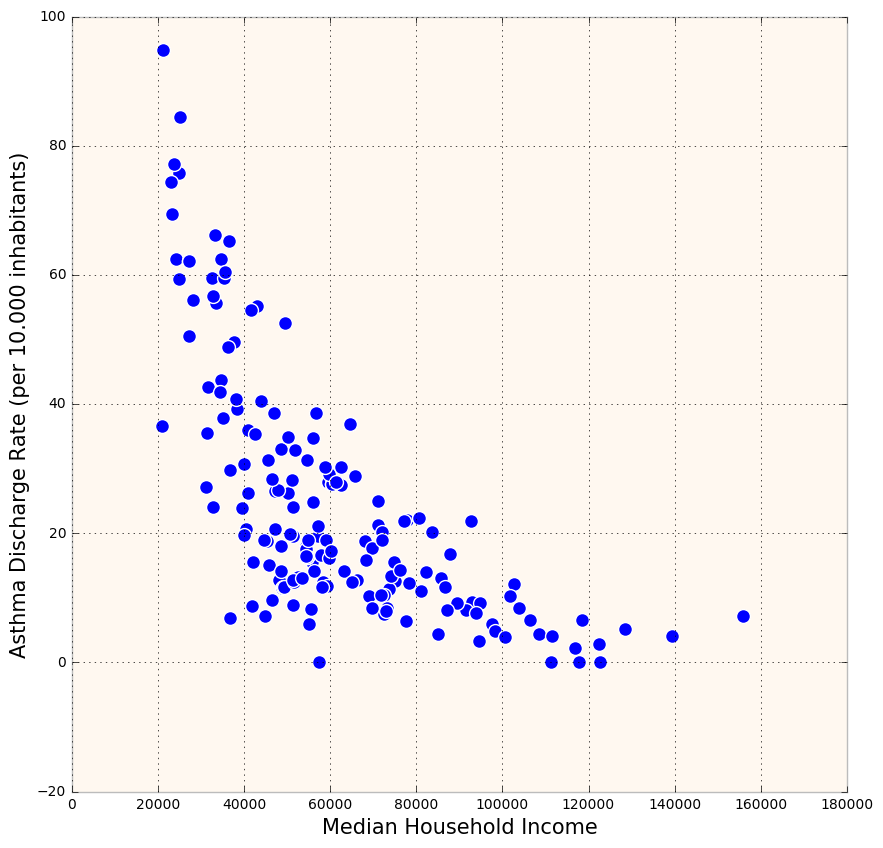

In [378]:
# Further exploration of the relationship betewen Asthma Discharge Rate and 
# other census attributes

pl.figure(figsize=(10,10))
pl.scatter(dsConsolidatedByZip.medianhouseholdincome,
           dsConsolidatedByZip.Rate, s=100)
pl.xlabel("Median Household Income", fontsize=15)
pl.ylabel("Asthma Discharge Rate (per 10.000 inhabitants)", fontsize=15)
pl.title("")

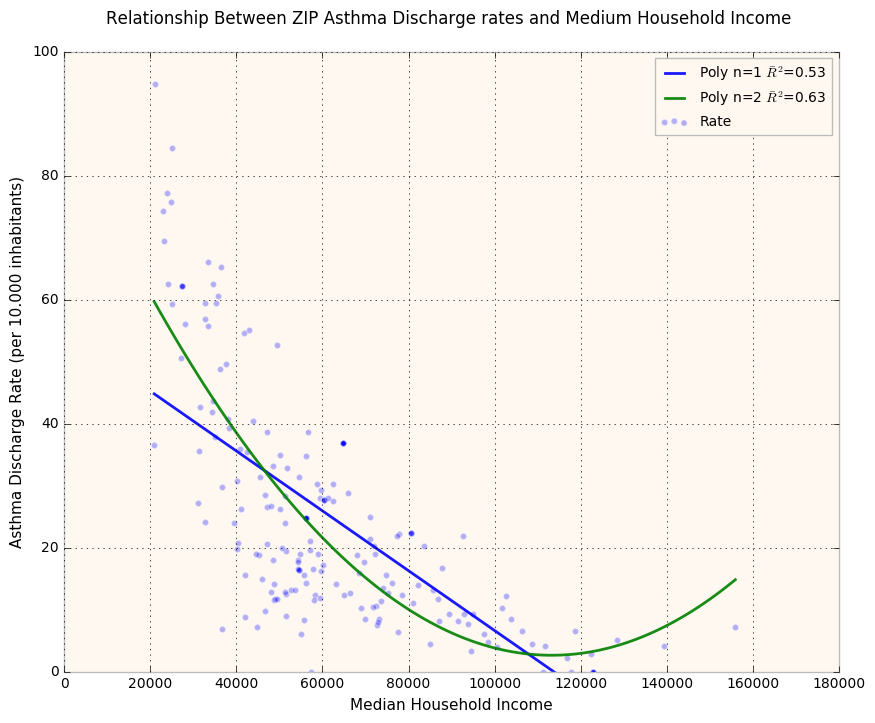

In [394]:
# Further refine the scatterplot and add regressions:

pl.figure(figsize=(10,8))
pl.scatter(dsConsolidatedByZip.medianhouseholdincome,
           dsConsolidatedByZip.Rate, s=20, alpha=0.3)
pl.xlabel("Median Household Income", fontsize=11)
pl.ylabel("Asthma Discharge Rate (per 10.000 inhabitants)", fontsize=11)
pl.title('Relationship Between ZIP Asthma Discharge rates and Medium Household Income \n',
        fontsize = 12)

pl.ylim(0,100)

# points linearlyd space on medianhouseholdincome from min to max , 100 points
x = pd.DataFrame({'medianhouseholdincome': \
                  np.linspace(dsConsolidatedByZip.medianhouseholdincome.min(),
                              dsConsolidatedByZip.medianhouseholdincome.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='Rate ~ 1 + medianhouseholdincome', data=dsConsolidatedByZip).fit()

pl.plot(x.medianhouseholdincome, poly_1.predict(x),
        'b-', label='Poly n=1 $\\bar R^2$=%.2f' % poly_1.rsquared_adj, alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='Rate ~ 1 + medianhouseholdincome \
+ I(medianhouseholdincome ** 2.0)', data=dsConsolidatedByZip).fit()

pl.plot(x.medianhouseholdincome,
        poly_2.predict(x), 'g-', label='Poly n=2 $\\bar R^2$=%.2f' % poly_2.rsquared_adj, alpha=0.9)

pl.legend()